In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float16)  # 由于LIF神经元相对比较简单，可以使用float16以节省显存
if torch.cuda.is_available():  # 优先使用gpu进行模拟
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'use device:{device}')
torch.set_grad_enabled(False) # 不使用自动梯度
torch.cuda.empty_cache() # 清空显存
dt = 0.5  # 模拟时间步长 ms
__t__ = 0  # 全局时间变量，用于计算不应期
class LIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5,spike_tau3=2,spike_tau15=5):
        self.shape = (n,n)  # 网络形态
        self.threshold = threshold  # 发放阈值
        self.reset_value = reset_value  # 回复和静息电位，单位mV
        self.membrane_capacitance = membrane_capacitance  # 膜电容，单位nF
        self.gL = gL  # 漏电导，单位μS
        self.refractory = refractory_period  # 不应期，单位ms
        self.potential = torch.ones(self.shape).to(device) * (self.reset_value)  # 膜电位，单位mV
        self.spike = torch.zeros(self.shape).to(device)
        self.spike_time = torch.ones(self.shape).to(device) * (-self.refractory*5)  # 上一次的发放时间

        self.spike_decay3 = torch.zeros(self.shape).to(device)
        self.spike_decay15 = torch.zeros(self.shape).to(device)
        self.spike_tau3 = spike_tau3
        self.spike_tau15 = spike_tau15

    def update(self, input:torch.Tensor):
        assert input.shape == self.shape
        self.potential += 1/self.membrane_capacitance*(
            -self.gL*(self.potential - self.reset_value) + input
        ) * dt  # 这一函数更新了膜电位
        
        # 以下函数处理神经元发放
        self.spike = torch.where(self.potential > self.threshold, 1, 0)  # 大于阈值的神经元
        self.if_refractory = torch.where(__t__ - self.spike_time > self.refractory, 1, 0)  # 不处在不应期的神经元
        self.spike = self.spike * self.if_refractory  # 二者同时满足才会发放动作电位

        #以下函数处理不应期和发放后的膜电位
        self.potential = torch.where(self.potential > self.threshold, self.reset_value, self.potential)  # 发放后返回静息电位
        self.potential = torch.where(__t__ - self.spike_time < self.refractory, self.reset_value, self.potential)  # 处在不应期的神经元返回静息电位

        self.spike_time = self.spike*(__t__ - self.spike_time) + self.spike_time  #更新上次发放时间
        self.spike_decay3 = self.spike_decay3*(1-dt/self.spike_tau3) + self.spike
        self.spike_decay15 = self.spike_decay15*(1-dt/self.spike_tau15) + self.spike
 
        return self.potential, self.spike, self.spike_decay3,self.spike_decay15

class Synapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int, W=0.02, sigma=18, time_constant=3.0, Vrest = 0.0):
        '''m_synapse must be odd. because in the unfold function, if m is even, the index will shift'''
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        assert out_neuron/in_neuron % 1 == 0 or in_neuron/out_neuron % 1 == 0  # 确保E_neurons和I_neurons的数量比是整数，以便于后续进行缩放

        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self.gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest
        self.i = torch.zeros((out_neuron,out_neuron)).to(device)

    def gaussian(self, n, W, sigma):
        x = torch.arange(n).view(1,-1).repeat(n, 1).to(device)
        y = torch.arange(n).view(-1,1).repeat(1, n).to(device)
        gaussian = W * torch.exp( - ((x - n//2) ** 2 + (y - n//2) ** 2) / sigma )  # 通过间距计算权重
        return gaussian
    
    def update(self, input: torch.Tensor, potential:torch.Tensor):
        assert input.shape == (self.in_neurons, self.in_neurons)

        if self.in_neurons<self.out_neurons:
            input = self.scale_up(input,self.out_neurons//self.in_neurons)
        else:
            input = self.scale_down(input,self.in_neurons//self.out_neurons)
        
        self.i = (torch.einsum('abij, ij->abij', input, self.weight)*(self.Vrest - potential).unsqueeze(2).unsqueeze(3).repeat(1,1,self.shape[2],self.shape[3])).sum(dim=(2,3))  # 将单个神经元的膜电位展开成和突触张量同阶数的张量
        return self.i
    
    def scale_up(self, input:torch.Tensor, zoom_rate:int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        # 以下四个表达式完成了二维矩阵的扩展，以便后面进行平移展开操作
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        # 平移展开，得到每个突触对应神经元的spike情况
        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)

        # 将较小的synapselayer的相邻元素重复，得到较大的layer的输入
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input
    
    def scale_down(self, input:torch.Tensor, zoom_rate:int): 
        # 和上面的同理
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input
     
class Network:
    def __init__(self, En, In, rp=5, We=0.02, Wi=0.01, frequency_timeconstant=100, frequency_criticalpoint=10) -> None:
        self.E_neurons = LIFlayer(n=En,refractory_period=rp)
        self.synapsesEE = Synapseslayer(En,En,101,W=We)
        self.synapsesEE_distal = Synapseslayer(En,En,151,W=0.000008,sigma=6000)
        self.synapsesEI = Synapseslayer(En,In,101,W=We)
        self.synapsesEI_distal = Synapseslayer(En,In,151,W=0.000004,sigma=60000)

        self.I_neurons = LIFlayer(n=In, refractory_period=rp)
        self.synapsesIE = Synapseslayer(In,En,101,Vrest=-80,sigma=300,W=Wi)
        self.synapsesII = Synapseslayer(In,In,101,Vrest=-80,sigma=300,W=Wi)

        self.spike = []
        self.frequency_timeconstant = frequency_timeconstant  # 单位ms，记录发放率平均值的时间跨度
        self.frequency_criticalpoint = frequency_criticalpoint

    def update(self, inputE:torch.Tensor, inputI:torch.Tensor):
        E_potential, E_spike,E_decay3,E_decay15 = self.E_neurons.update(inputE+self.synapsesEE.i+self.synapsesIE.i+self.synapsesEE_distal.i)
        I_potential, I_spike,I_decay3,I_decay15 = self.I_neurons.update(inputI+self.synapsesII.i+self.synapsesEI.i+self.synapsesEI_distal.i)
        self.synapsesEE.update(E_decay3, E_potential)
        self.synapsesEI.update(E_decay3, I_potential)
        self.synapsesIE.update(I_decay3, E_potential)
        self.synapsesII.update(I_decay3, I_potential)
        self.synapsesEE_distal.update(E_decay15, E_potential)
        self.synapsesEI_distal.update(E_decay15, I_potential)

        return E_potential,E_decay3, self.synapsesEE_distal.i

use device:cuda


100%|██████████| 2000/2000 [13:03<00:00,  2.55it/s]


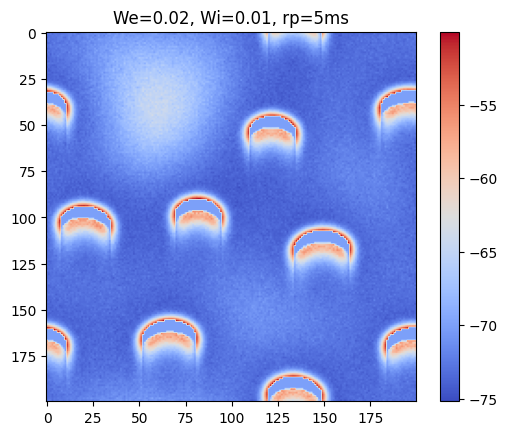

In [19]:
En = 200
In = 100
runtime1 = 30  # 有外界输入的时间
runtime = 1000  # 自发动力学的时间
rp = 5
We = 0.02
Wi = 0.01
net = Network(En,In,rp=rp,We=We,Wi=Wi)
voltage_list = []
decay_list = []

import tqdm
for i in tqdm.tqdm(range(int(runtime1/dt))):
    __t__+=dt
    E_potential, E_spike,E_spike15= net.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)  # 平均外界输入电流2.5nA
    voltage_list.append(E_potential.clone().cpu())
    

for i in tqdm.tqdm(range(int(runtime/dt))):
    __t__+=dt
    E_potential, E_spike,E_spike15= net.update(torch.rand((En,En)).to(device)*1, torch.rand((In,In)).to(device)*1)
    voltage_list.append(E_potential.clone().cpu())
    decay_list.append(E_spike15)


plt.imshow(E_potential.cpu(), cmap='coolwarm')
plt.title(f'We={We}, Wi=0.01, rp={rp}ms')
plt.colorbar()
plt.show()


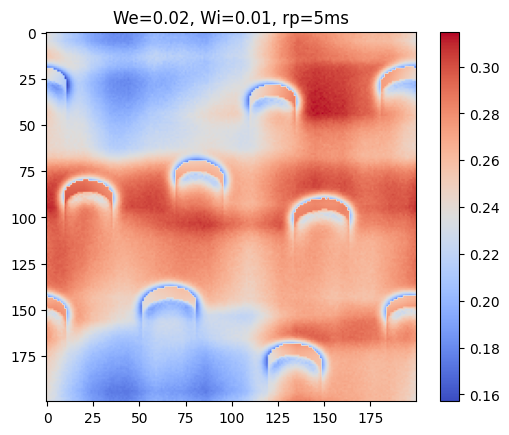

In [20]:
data = decay_list[1700].cpu()
# data = np.concatenate((data,data,data),0)
# data = np.concatenate((data,data,data),1)
plt.imshow(data, cmap='coolwarm')
plt.title(f'We={We}, Wi=0.01, rp={rp}ms')
plt.colorbar()
plt.show()


In [1]:
plt.imshow(voltage_list[30].cpu(), cmap='coolwarm')
plt.title(f'We={We}, Wi=0.01, rp={rp}ms')
plt.colorbar()
plt.show()


NameError: name 'plt' is not defined

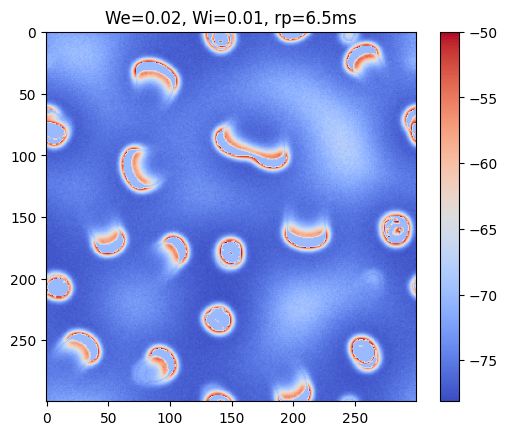

In [89]:
plt.imshow(voltage_list[200].cpu(), cmap='coolwarm')
plt.title(f'We={We}, Wi=0.01, rp={rp}ms')
plt.colorbar()
plt.show()


In [17]:
# 可以保存数据，使用Watch_Pattern.py观看动画
V = np.array([v.numpy() for v in voltage_list])
np.save(f'distal01.npy',V)

# 可以保存数据，使用Watch_Pattern.py观看动画
np.save(f'distal_long.npy',np.array([decay_list[i].cpu() for i in range(decay_list.__len__())]))